This exploratory python notebook is heavily inspired by:
- https://www.datacamp.com/tutorial/tutorial-lasso-ridge-
- https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html

In [1]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_boston
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt

Problem statement:

We are given information on:
- Demography in the districts (blocks)
- Location of the districts  
- Aggregated characteristics of houses in the district 

Can we predict the median house value in an arbitrary district?

Predicting the median price of house (a real number) in an unknown district is a regression problem.

In [2]:
california_housing = fetch_california_housing(as_frame=True)
print(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [3]:
# Looking into the information contained in the datset
california_housing.frame.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In this dataset, we have information (features):
- Demography (income, population, house occupancy) in the districts (blocks)
- Location of the districts (latitude, longitude), 
- Aggregated characteristics of houses in the district (number of rooms, number of bedrooms, age of the house)

In [4]:
# Looking into features
california_housing.data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [5]:
# Looking into targets
california_housing.target.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

We can now check more into details the data types and if the dataset contains any missing value.

In [6]:
california_housing.frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


We can see that:
- the dataset contains 20,640 samples and 8 features;
- all features are numerical features encoded as floating number;
- there is no missing values.

Let’s have a quick look at the distribution of these features by plotting their histograms.

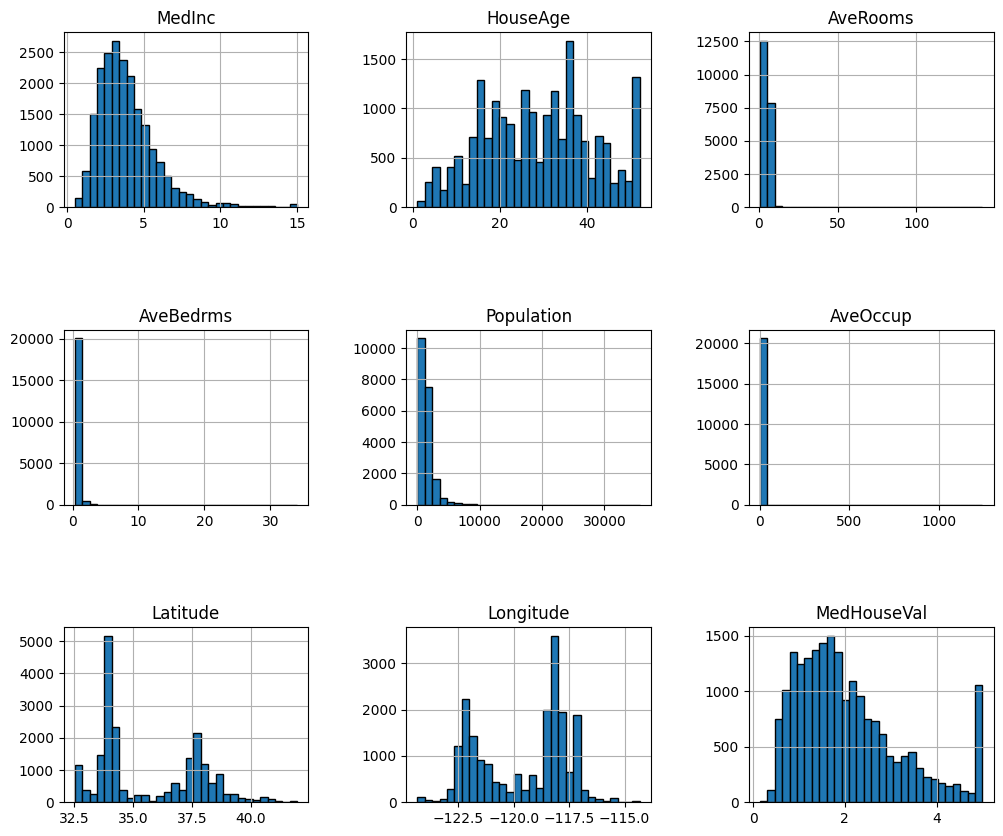

In [7]:
california_housing.frame.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

We can first focus on features for which their distributions would be more or less expected.
- The median income is a distribution with a long tail. It means that the salary of people is more or less normally distributed but there is some people getting a high salary.
- The average house age, the distribution is more or less uniform.
- The target distribution has a long tail as well. In addition, we have a threshold-effect for high-valued houses: all houses with a price above 5 are given the value 5.
- Average rooms, average bedrooms, average occupation, and population, the range of the data is large with unnoticeable bin for the largest values. It means that there are very high and few values (maybe they could be considered as outliers?)

Let us look into geographical disctribution of the data. We can make a scatter plot where the x- and y-axis would be the latitude and longitude and the circle size and color would be linked with the house value in the district.

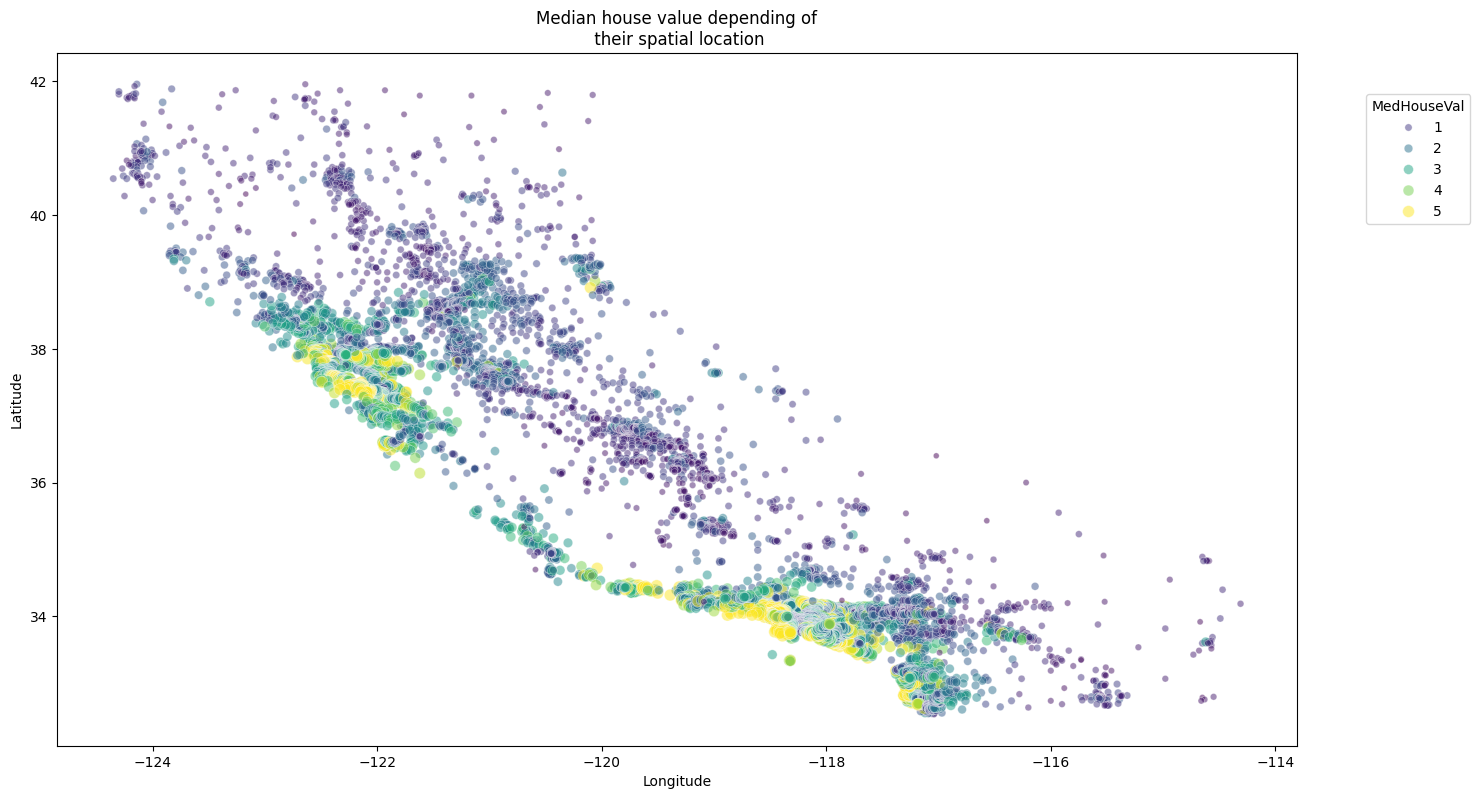

In [8]:
import seaborn as sns
plt.figure(figsize=(16, 9))
sns.scatterplot(
    data=california_housing.frame,
    x="Longitude",
    y="Latitude",
    size="MedHouseVal",
    hue="MedHouseVal",
    palette="viridis",
    alpha=0.5    
)

plt.legend(title="MedHouseVal", bbox_to_anchor=(1.05, 0.95), loc="upper left")
_ = plt.title("Median house value depending of\n their spatial location")

Quizz 1a: Can you guess what point A and B may represent?
Quizz 1b: The plot suggest that a addition data could help modeling the problem. Can you think about an example or two?

In [9]:
# Drop the unwanted columns
rng = np.random.RandomState(0)
indices = rng.choice(
    np.arange(california_housing.frame.shape[0]), size=500, replace=False
)
columns_drop = ["Longitude", "Latitude"]
subset = california_housing.frame.iloc[indices].drop(columns=columns_drop)
# Quantize the target and keep the midpoint for each interval
subset["MedHouseVal"] = pd.qcut(subset["MedHouseVal"], 6, retbins=False)
subset["MedHouseVal"] = subset["MedHouseVal"].apply(lambda x: x.mid)

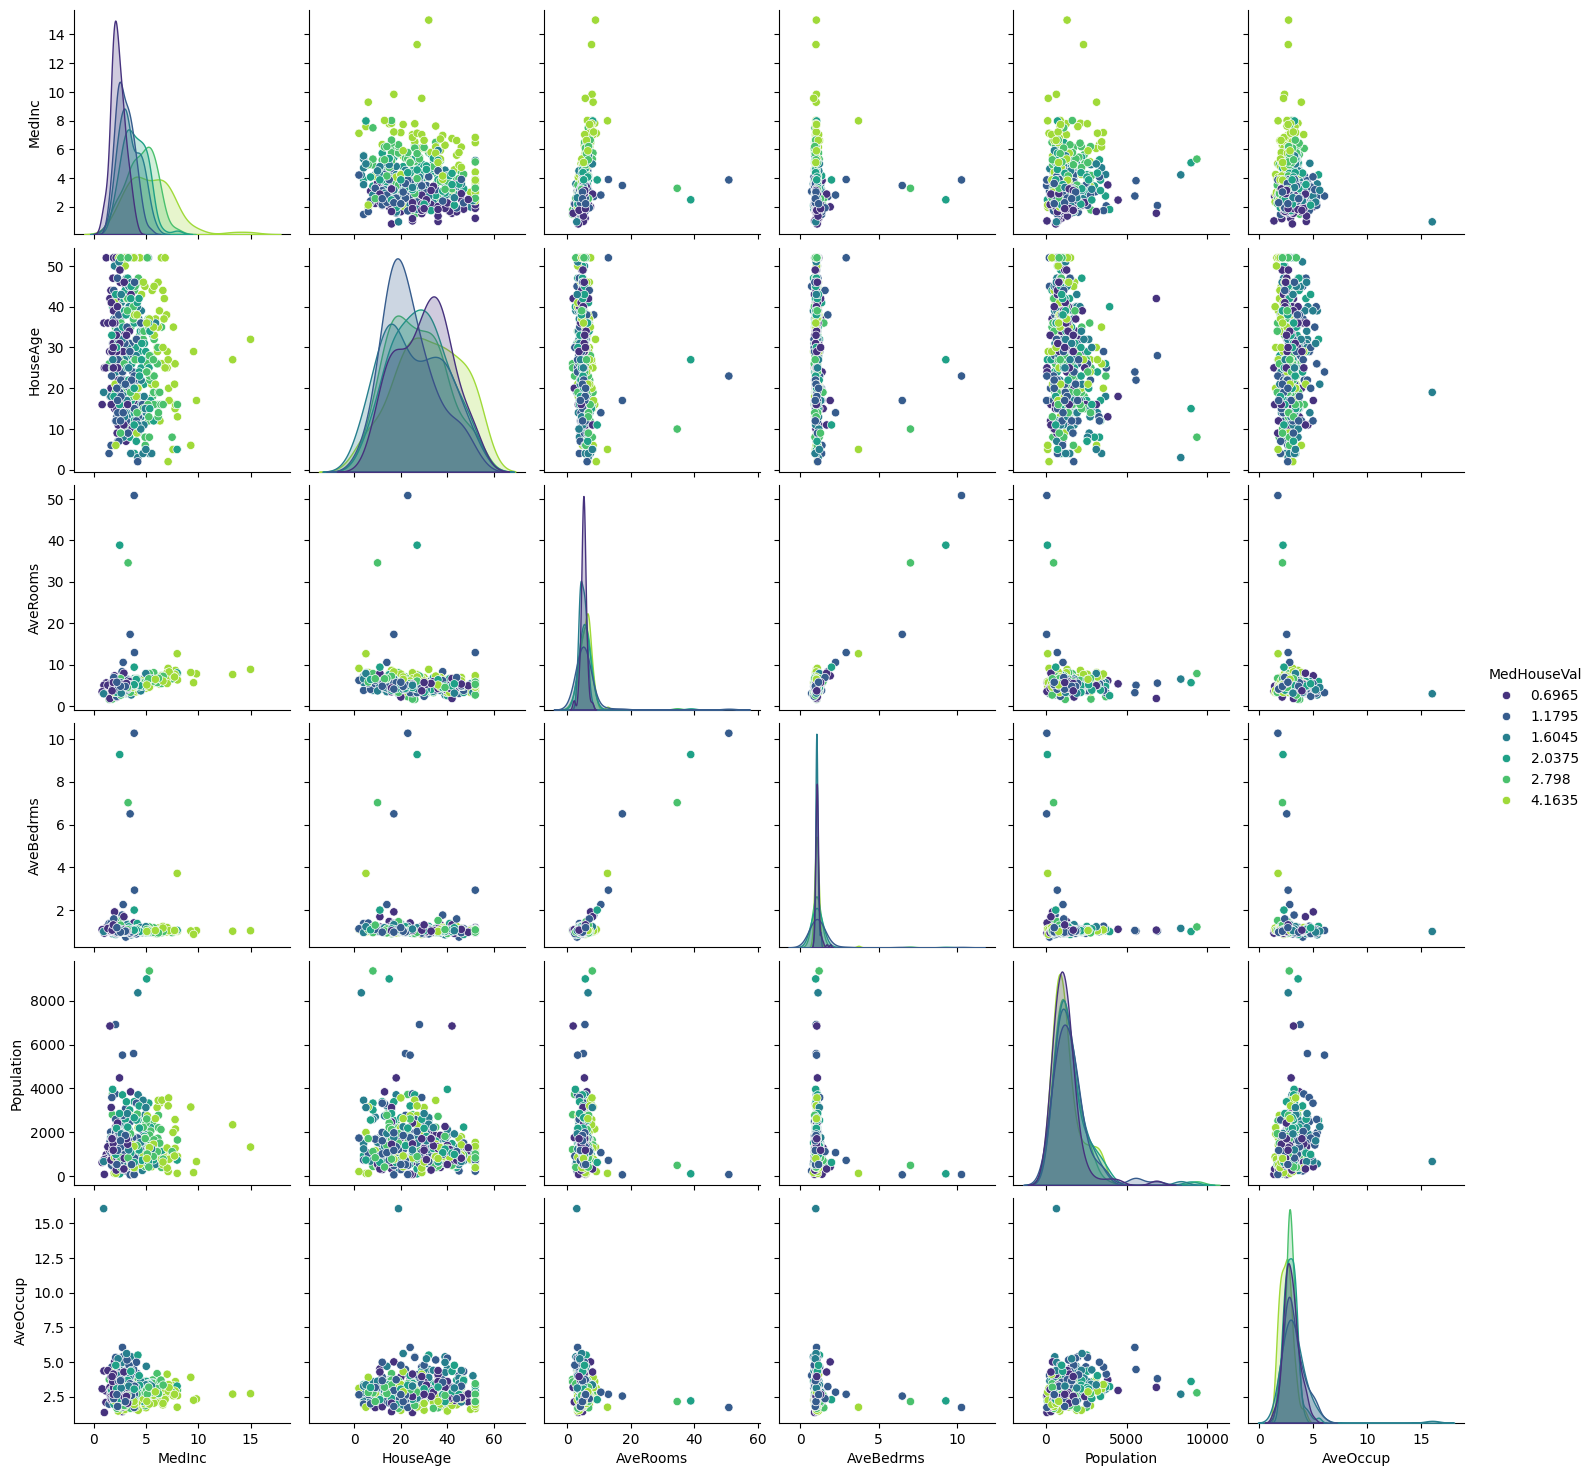

In [10]:
_ = sns.pairplot(data=subset, hue="MedHouseVal", palette="viridis")

# Linear regression and regularized linear regression

In [11]:
# Separating our feature variable from the target variable.
features = california_housing.frame.columns[0:8]
target = california_housing.frame.columns[-1]

#X and y values
X = california_housing.frame[features].values
y = california_housing.frame[target].values

#split your data in two partitions
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=17
)

print("Number of training data points {}".format(X_train.shape))
print("Number of testing data points {}".format(X_test.shape))

Number of training data points (16512, 8)
Number of testing data points (4128, 8)


In [12]:
#Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # fit_tranform allows us to use the same scaling on the test dataset
X_test = scaler.transform(X_test)

In [13]:
#A simple linear regression model 
lr = LinearRegression()

#Fit model the model
lr.fit(X_train, y_train) # This finds (m, b) so that sum of errors sqaured is minimized

train_score_lr = lr.score(X_train, y_train) # The score is Rsquared
test_score_lr = lr.score(X_test, y_test)

print("The train score (RSquared) for lr model is {}".format(train_score_lr))
print("The test score (RSquared) for lr model is {}".format(test_score_lr))

The train score (RSquared) for lr model is 0.6069093522861393
The test score (RSquared) for lr model is 0.6027364496734411


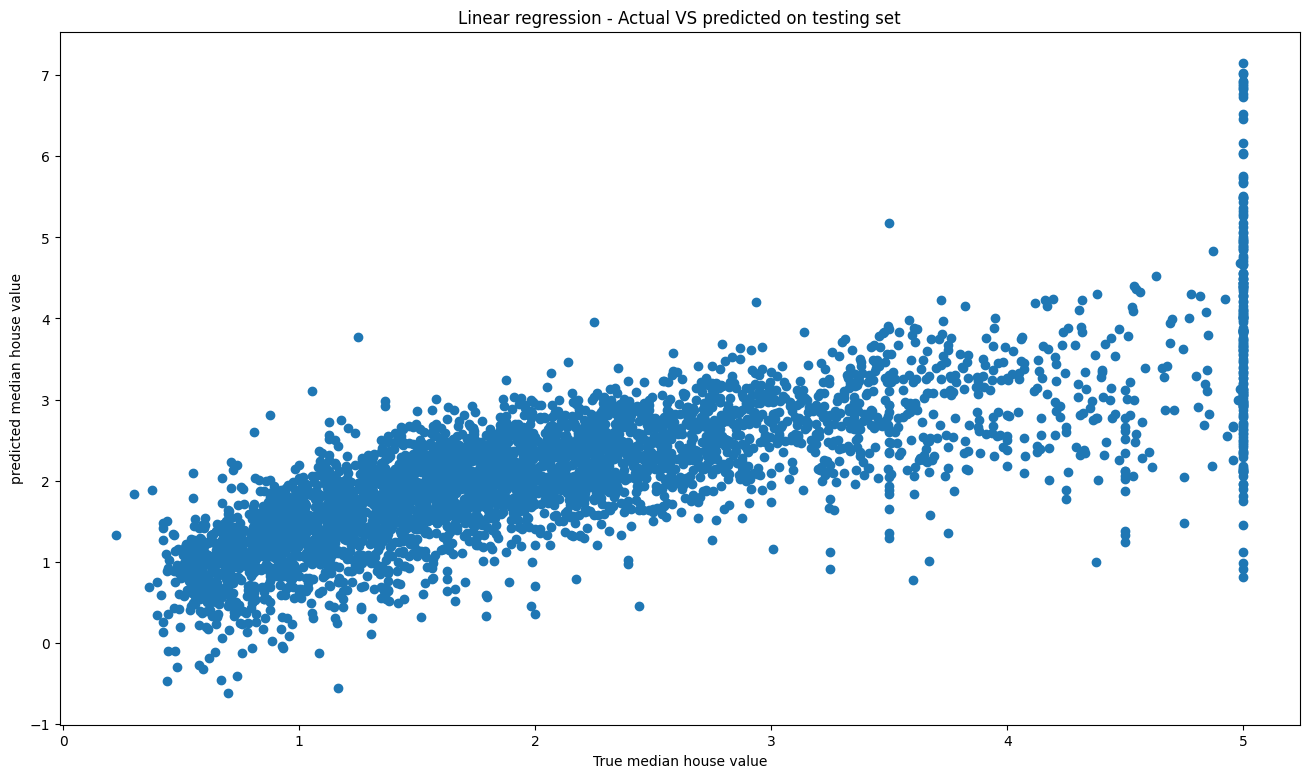

In [24]:
# Predict y_hat on the test set
y_pred_lr = lr.predict(X_test)

#, title='Training set: True medianHouseValue VS predicted medianHouseValue'
plt.figure(figsize=(16, 9))
plt.xlabel("True median house value")  # Set label for X axis
plt.ylabel("predicted median house value")  # Set label for Y axis
plt.title("Linear regression - Actual VS predicted on testing set")  # Set label for Y axis
plt.scatter(y_test, y_pred_lr)

Quiz 3: What do we think about predictions made for districts with median house price > 5?
Should these points be treated differently?

In [25]:
#Ridge Regression Model
ridgeReg = Ridge(alpha=0.04) 

ridgeReg.fit(X_train, y_train)

#train and test scorefor ridge regression
train_score_ridge = ridgeReg.score(X_train, y_train)
test_score_ridge = ridgeReg.score(X_test, y_test)

print("\nRidge Model............................................\n")
print("The train score for ridge model is {}".format(train_score_ridge))
print("The test score for ridge model is {}".format(test_score_ridge))


Ridge Model............................................

The train score for ridge model is 0.6069093521765386
The test score for ridge model is 0.602736356999463


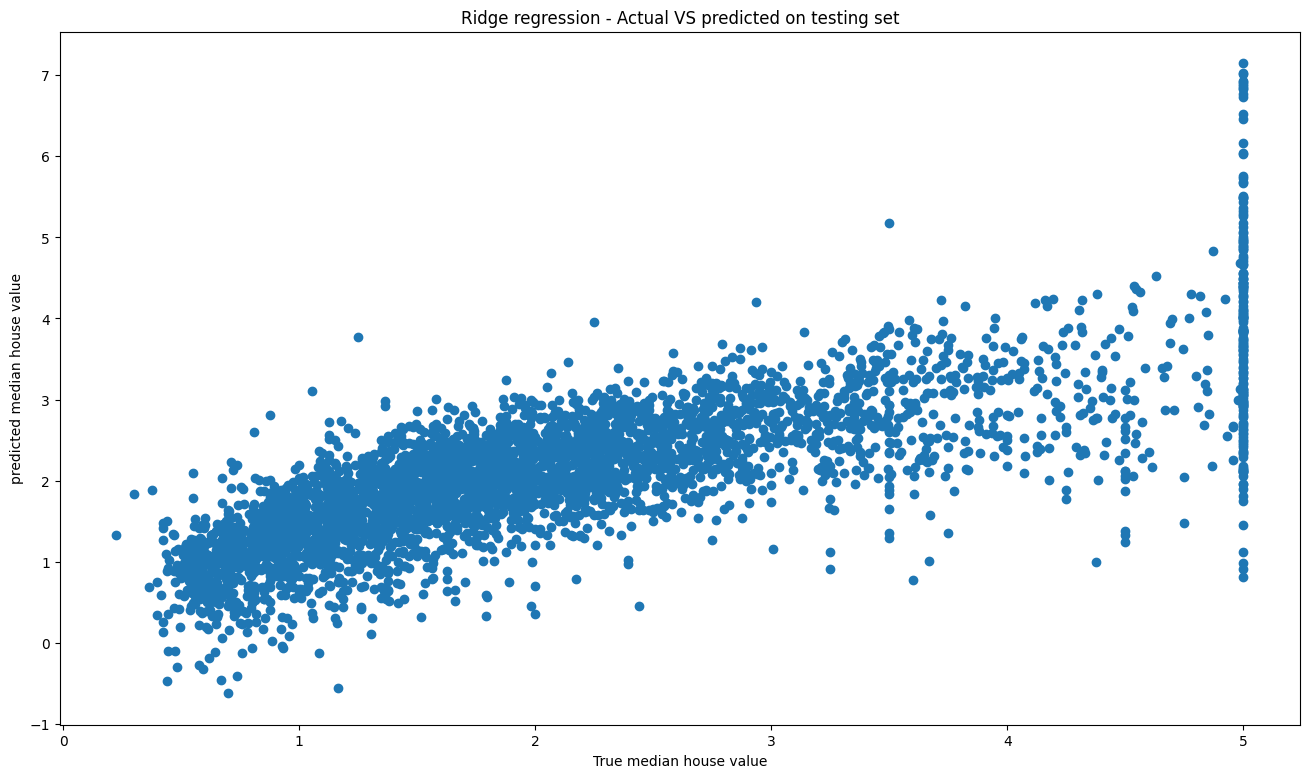

In [26]:
y_pred_rigde = ridgeReg.predict(X_test)

#, title='Training set: True medianHouseValue VS predicted medianHouseValue'
plt.figure(figsize=(16, 9))
plt.xlabel("True median house value")  # Set label for X axis
plt.ylabel("predicted median house value")  # Set label for Y axis
plt.title("Ridge regression - Actual VS predicted on testing set")  # Set label for Y axis
plt.scatter(y_test, y_pred_rigde)

In [27]:
#Lasso regression model
lasso = Lasso(alpha = 0.04)
lasso.fit(X_train, y_train)
train_score_ls = lasso.score(X_train,y_train)
test_score_ls = lasso.score(X_test,y_test)

print("The train score for ls model is {}".format(train_score_ls))
print("The test score for ls model is {}".format(test_score_ls))

The train score for ls model is 0.56386862270722
The test score for ls model is 0.5588790707324476


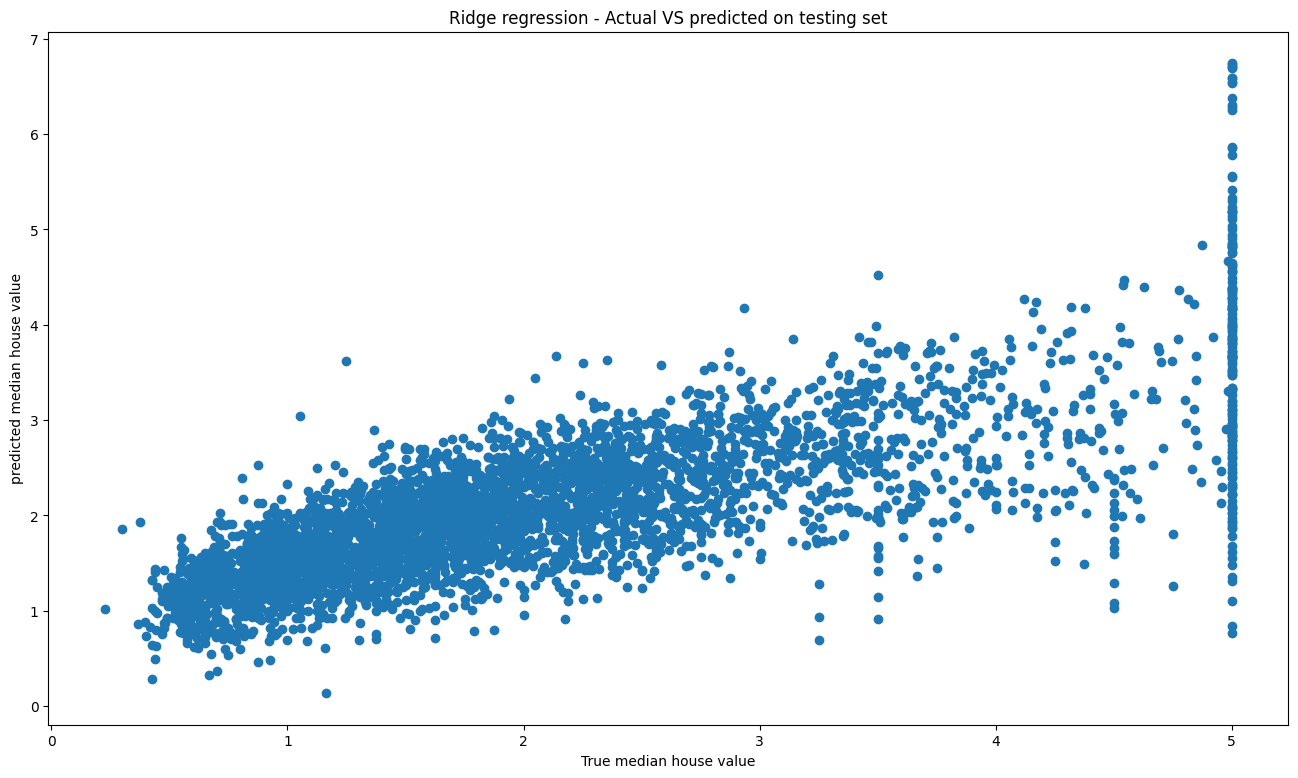

In [28]:
y_pred_lasso = lasso.predict(X_test)

plt.figure(figsize=(16, 9))
plt.xlabel("True median house value")  # Set label for X axis
plt.ylabel("predicted median house value")  # Set label for Y axis
plt.title("Ridge regression - Actual VS predicted on testing set")  # Set label for Y axis
plt.scatter(y_test, y_pred_lasso)


In [29]:
from sklearn.metrics import mean_squared_error
import numpy as np
r_squared_lin_regression = lr.score(X_test,y_test)
r_squared_ridge_regression = ridgeReg.score(X_test,y_test)
r_squared_lasso_regression = lasso.score(X_test,y_test)
rmse_lin_regression =  np.sqrt(mean_squared_error(y_test, y_pred_lr))
rmse_ridge_regression = np.sqrt(mean_squared_error(y_test, y_pred_rigde))
rmse_lasso_regression = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

In [20]:
r_squared_values = [
    r_squared_lin_regression,
    r_squared_ridge_regression,
    r_squared_lasso_regression
]

rmse_values = [
    rmse_lin_regression,
    rmse_ridge_regression,
    rmse_lasso_regression
]

print(r_squared_values)
print(rmse_values)

[0.6027364496734411, 0.602736440415643, 0.6014805956662422]
[0.7207313358546283, 0.7207313442525611, 0.7218696470880012]


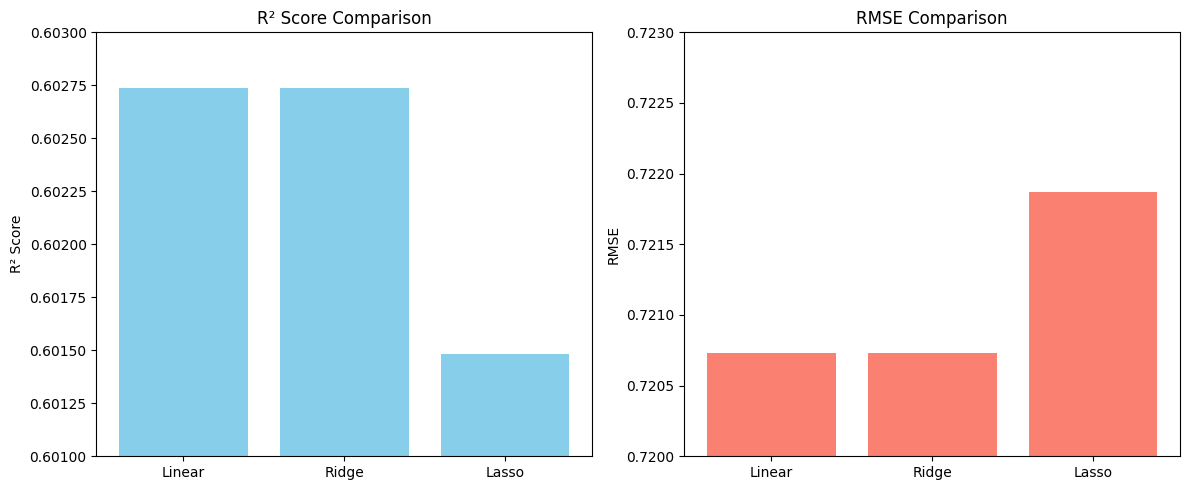

In [21]:

models = ['Linear', 'Ridge', 'Lasso']

# Set figure size
plt.figure(figsize=(12, 5))

# Plot R²
plt.subplot(1, 2, 1)
plt.bar(models, r_squared_values, color='skyblue')
plt.title('R² Score Comparison')
plt.ylabel('R² Score')
plt.ylim(0.601, 0.603)  # Adjust based on your scores

# Plot RMSE
plt.subplot(1, 2, 2)
plt.bar(models, rmse_values, color='salmon')
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.ylim(0.720, 0.723)  # Adjust based on your scores

plt.tight_layout()
plt.show()

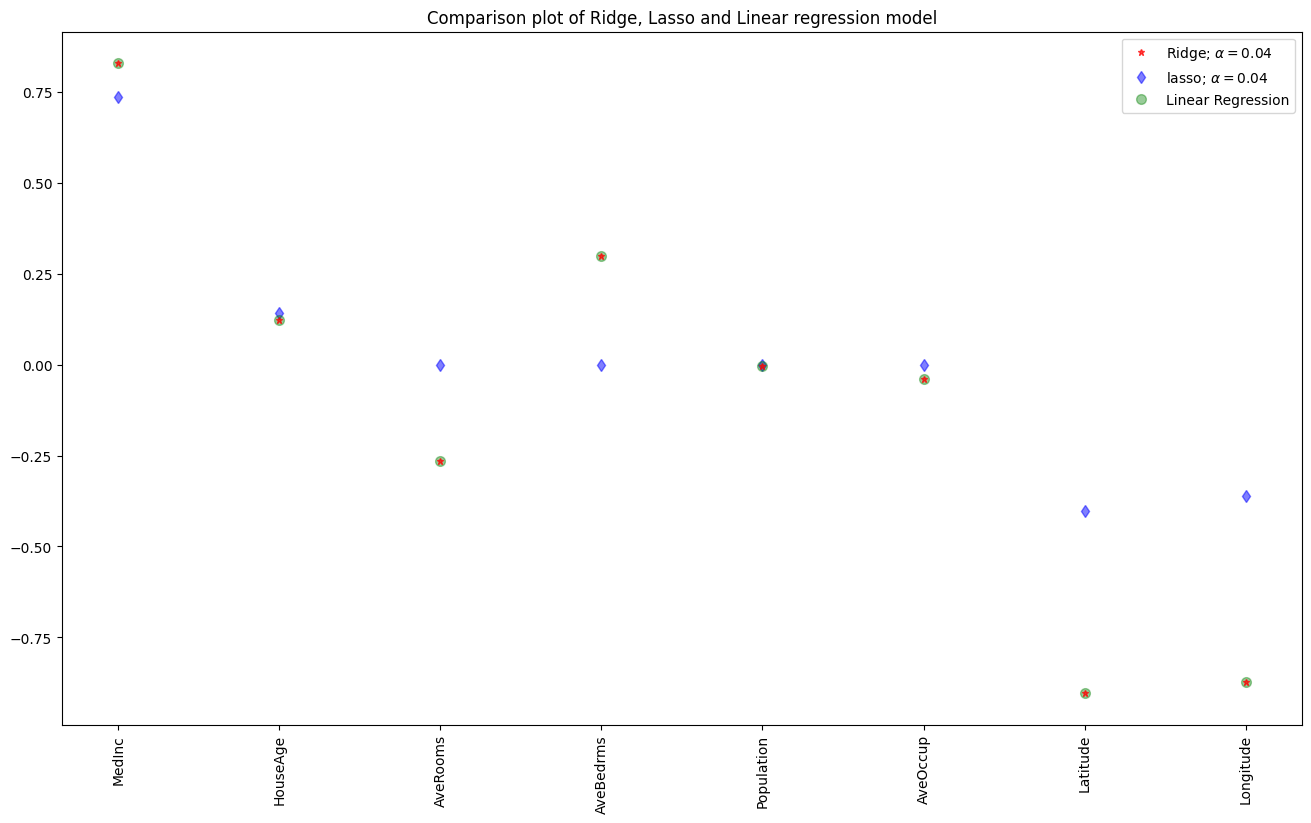

In [31]:
#plot size
plt.figure(figsize = (16, 9))
#add plot for ridge regression
plt.plot(features,ridgeReg.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 0.04$',zorder=7)

#add plot for lasso regression
plt.plot(lasso.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'lasso; $\alpha = 0.04$')

#add plot for linear model
plt.plot(features,lr.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')

#rotate axis
plt.xticks(rotation = 90)
plt.legend()
plt.title("Comparison plot of Ridge, Lasso and Linear regression model")
plt.show()

In [1]:
#Quiz 5: Which model is the simplest? 